Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when the cells are run one at a time sequentially, not all at once.

## Clean Air Act Violations by Congressional District

This notebook examines ECHO data using ICIS-AIR_VIOLATION_HISTORY. It focuses especially on those violations that EPA deems most environmentally concerning, or High Priority Violations" (HPV). To determine the timing of these types of violations, the HPV_DAYZERO_DATE reporting the start date of every episode of High Priority Violation (HPV) is used. The PGM_SYS_ID facility identifier is linked to the ECHO_EXPORTER table's AIR_IDS field for each facility overseen by the EPA under the Clean Air Act.

**A state and congressional district must be chosen using the dropdown widgets that are provided.**

Note:  This notebook has widgets to select the state, congressional district and facility.  Those currently work only when you **run cells one at a time sequentially, not all at once.**

## How to Run
* If you click on a gray **code** cell, a little “play button” arrow appears on the left. If you click the play button, it will run the code in that cell (“**running** a cell”). The button will animate. When the animation stops, the cell has finished running.
![Where to click to run the cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/pressplay.JPG?raw=true)
* You may get a warning that the notebook was not authored by Google. We know, we authored them! It’s okay. Click “Run Anyway” to continue. 
![Error Message](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/warning-message.JPG?raw=true)
* **It is important to run cells in order because they depend on each other.**
* Some cells, like the one shown below, will create a dropdown menu after you run them. Be sure to make a selection (for example, click to change NY to LA) before running the next cell.
![Dropdown menu](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/dropdown.JPG?raw=true)
* Other cells will simply print information when you run them, like this one:
![Simple cell](https://github.com/edgi-govdata-archiving/EEW-Image-Assets/blob/master/Jupyter%20instructions/cell-simple.JPG?raw=true)
* Run all of the cells in a Notebook to make a complete report. Please feel free to look at and **learn about each result as you create it**!




**Let's Begin!**

**1. Hover over the "[ ]" on the top left corner of the cell below and you should see a "play" button appear. Click on it to run the cell then move to the next one.**

In [1]:
# Import libraries
import urllib.parse
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import folium

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import display


**2. Run this next cell to create the widget for selecting states. It will create a dropdown menu at the bottom. Choose your state from the menu then move on to the next cell.**

In [2]:
states = ["AL", "AK", "AZ", "AR", "CA", "CO", "CT", "DC", "DE", "FL", "GA", 
          "HI", "ID", "IL", "IN", "IA", "KS", "KY", "LA", "ME", "MD", 
          "MA", "MI", "MN", "MS", "MO", "MT", "NE", "NV", "NH", "NJ", 
          "NM", "NY", "NC", "ND", "OH", "OK", "OR", "PA", "RI", "SC", 
          "SD", "TN", "TX", "UT", "VT", "VA", "WA", "WV", "WI", "WY"]
dropdown_state=widgets.Dropdown(
    options=states,
    value='NY',
    description='State:',
    disabled=False,
)
output_state = widgets.Output()
my_state = ""

def dropdown_state_eventhandler( change ):
    output_state.clear_output()
    value = change.new
    with output_state:
        display( change.new )
            
dropdown_state.observe( dropdown_state_eventhandler, names='value')
display( dropdown_state )

Dropdown(description='State:', index=32, options=('AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', …

**3. Run this cell after choosing a state. It will pull the data for that state from ECHO**

In [3]:
#Here, we are defining the state you chose in the dropdown menu as your state
my_state = dropdown_state.value 

#This is where we use SQL to select the data related to your state from the Stonybrook ECHO database.
#Other parameters we are selecting include the facility name, latitude, longitude, AIR ID...
sql = "select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113 " + \
    " from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = '" + my_state + "'" 
url='http://apps.tlt.stonybrook.edu/echoepa/?query=' #this is the URL where the database lives
data_location=url+urllib.parse.quote(sql) #here, we tell the computer where our data picked by our SQL query will come from.
print(sql) #this is the SQL query we are sending to the database.
print(data_location) #this produces a link to where the data from our SQL query lives. We will import this data for the analysis.

select FAC_NAME, FAC_STATE, FAC_LAT, FAC_LONG, AIR_IDS, FAC_DERIVED_CD113  from ECHO_EXPORTER where AIR_FLAG = 'Y' and FAC_STATE = 'LA'
http://apps.tlt.stonybrook.edu/echoepa/?query=select%20FAC_NAME%2C%20FAC_STATE%2C%20FAC_LAT%2C%20FAC_LONG%2C%20AIR_IDS%2C%20FAC_DERIVED_CD113%20%20from%20ECHO_EXPORTER%20where%20AIR_FLAG%20%3D%20%27Y%27%20and%20FAC_STATE%20%3D%20%27LA%27


**4. Run this cell to load the CSV of that data. Then, we will be able to analyze it!**

In [4]:

echo_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)


**5. Run this cell after choosing a state from the dropdown list.**

In [5]:
num_facilities = echo_data.shape[0]
print("There are %s ICIS facilities in %s tracked in the ECHO database." %(num_facilities, my_state))

There are 12702 ICIS facilities in LA tracked in the ECHO database.


**6. Run this next cell to generate the Congressional District dropdown list for your state.  Then select a CD and run the following cell. Here is a map of congressional districts if you need help choosing: https://www.govtrack.us/congress/members/map**

In [6]:
if (( my_state != 'none' ) & (my_state != 'all' )):
    cd_array = echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int).unique()
    cd_array.sort()
    w2=widgets.Dropdown(
        options=cd_array,
        value=1,
        description='Congressional Districts:',
        disabled=False,
    )
    display(w2)

Dropdown(description='Congressional Districts:', index=1, options=(0, 1, 2, 3, 4, 5, 6, 18), value=1)


Run this next cell after choosing a congressional district from the dropdown list. You will then see the total number of ICIS (EPA's Integrated Compliance System) facilities are being regulated in your district under the Clean Air Act.

In [7]:
my_cd = w2.value
my_cd_facs = echo_data[echo_data["FAC_DERIVED_CD113"].fillna(0).astype(int) == my_cd]
num_facilities = my_cd_facs.shape[0]    
print("There are %s ICIS facilities in %s district %s tracked in the ECHO database." %(num_facilities, my_state, my_cd))

There are 609 ICIS facilities in LA district 2 tracked in the ECHO database.


Next look up the high-priority violation history for the facilities in the selected
state and congressional district.  This step may take awhile.

In [8]:
sql = "select PGM_SYS_ID, HPV_DAYZERO_DATE, POLLUTANT_DESCS, AGENCY_TYPE_DESC " + \
    "from `ICIS-AIR_VIOLATION_HISTORY` where STATE_CODE='" + my_state + "'"
url='http://apps.tlt.stonybrook.edu/echoepa/?query='
data_location=url+urllib.parse.quote(sql)

icis_data = pd.read_csv(data_location,encoding='iso-8859-1',header = 0)
icis_data.set_index( "PGM_SYS_ID", inplace=True)


In [9]:
# The AIR_IDS can contain multiple ids for a facility. 
# The string must be parsed to get each individual id to look up in ICIS-AIR_VIOLATION_HISTORY.

my_cd_icis = pd.DataFrame()
no_data_ids = []
# Look through all facilities in my CD.
for fac in my_cd_facs.itertuples():
    # print( type( fac ))
    # breakpoint()
    ids = fac.AIR_IDS
    # Look at each AIR_ID belonging to the facility
    for air_id in ids.split():
        try:
            # Find the air_id in the ICIS-AIR_VIOLATION_HISTORY, if any exist there.
            # It can match a PGM_SYS_ID, which is the index of icis_data.
            air_data = icis_data.loc[ air_id ].copy()
            # Add the facility's index number to air_data, to refer to it.
            n = air_data.shape[0]
            fac_list = [fac.Index] * n
            air_data['facility'] = fac_list
            # Make a frame that contains the violations.  Add it to my_cd_icis.
            frames = [my_cd_icis, air_data]
            my_cd_icis = pd.concat( frames, ignore_index=False )
        except KeyError:
            # The air_id wasn't found in ICIS-AIR_VIOLATION_HISTORY.
            no_data_ids.append( air_id )
 
# my_cd_icis.to_csv( r'my_cd_icis.csv', index=True, header=True )
# with open( "no_data_ids.txt", "w" ) as output:
#     output.write( str( no_data_ids ))
my_cd_icis

/Users/enost/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'int' and 'str', sort order is undefined for incomparable objects
  result = result.union(other)
/Users/enost/anaconda3/lib/python3.7/site-packages/pandas/core/indexes/api.py:107: RuntimeWarning: '<' not supported between instances of 'str' and 'int', sort order is undefined for incomparable objects
  result = result.union(other)
/Users/enost/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:23: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.



,0,HPV_DAYZERO_DATE,POLLUTANT_DESCS,AGENCY_TYPE_DESC,facility
HPV_DAYZERO_DATE,04-15-2007,NaN,NaN,NaN,NaN
POLLUTANT_DESCS,NaN,NaN,NaN,NaN,NaN
AGENCY_TYPE_DESC,State,NaN,NaN,NaN,NaN
facility,"[44, 44, 44]",NaN,NaN,NaN,NaN
HPV_DAYZERO_DATE,NaN,NaN,NaN,NaN,NaN
POLLUTANT_DESCS,FACIL,NaN,NaN,NaN,NaN
AGENCY_TYPE_DESC,State,NaN,NaN,NaN,NaN
facility,"[50, 50, 50]",NaN,NaN,NaN,NaN
HPV_DAYZERO_DATE,07-09-2004,NaN,NaN,NaN,NaN
POLLUTANT_DESCS,FACIL,NaN,NaN,NaN,NaN


Map the facilities that have had these serious CAA violations. Within the "results" table, NaN=no available data; and AGENCY-TYPE-DESC=type of governmental agency handling, i.e., Local, State, or U.S. EPA; and POLLUTANT_DESC=type of air pollutant involved, such as Volatile Organic Compounds, Lead, or FACIL (latter indicates no particular pollutant involved, as violation concerns recordkeeping or paperwork).

In [10]:
fac_idx_list = my_cd_icis['facility'].dropna()
fac_cd_icis = my_cd_facs.loc[fac_idx_list]
print( my_cd_icis )

                                        0 HPV_DAYZERO_DATE  \
HPV_DAYZERO_DATE               04-15-2007              NaN   
POLLUTANT_DESCS                       NaN              NaN   
AGENCY_TYPE_DESC                    State              NaN   
facility                     [44, 44, 44]              NaN   
HPV_DAYZERO_DATE                      NaN              NaN   
POLLUTANT_DESCS                     FACIL              NaN   
AGENCY_TYPE_DESC                    State              NaN   
facility                     [50, 50, 50]              NaN   
HPV_DAYZERO_DATE               07-09-2004              NaN   
POLLUTANT_DESCS                     FACIL              NaN   
AGENCY_TYPE_DESC                    State              NaN   
facility                  [133, 133, 133]              NaN   
LA0000002208900015                    NaN       04-02-2006   
LA0000002208900015                    NaN              NaN   
HPV_DAYZERO_DATE               03-30-2003              NaN   
POLLUTAN

Save the data to a CSV file in your Google Drive.
The first of the next three cells will open our Google Drive to write into.
The second cell writes the congressional district file.
The third cell writes the file for state data.
Running these cells is optional.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Write the congressional district data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/cd-air-violations-' + my_state + '-' + str( my_cd ) + '.csv'
my_cd_icis.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

Write the state data to CSV file.

In [ ]:
filename = '/content/drive/My Drive/state-air-violations-' + my_state + '.csv'
icis_data.to_csv( filename ) 
print( "Writing this data to %s" %(filename))

In [ ]:
# Let's show a quick map of your area and the facilities in it

def mapper(df):
    # Initialize the map
    m = folium.Map(
        location = [df.mean()["FAC_LAT"], df.mean()["FAC_LONG"]],
        zoom_start = 11
    )

    # Add a clickable marker for each facility
    for index, row in df.iterrows():
        folium.Marker(
            location = [row["FAC_LAT"], row["FAC_LONG"]],
            popup = row["FAC_NAME"] ).add_to(m)

    # Show the map
    return m

map_of_facilities_in_my_area = mapper(fac_cd_icis)
map_of_facilities_in_my_area

Present another dropdown with the list of names of the facilities.  Choosing a facility will display
the violations.

In [ ]:
cd_array = fac_cd_icis["FAC_NAME"].unique()
cd_array.sort()

w3=widgets.Dropdown(
    options=cd_array,
    description='Facility Name:',
    disabled=False,
)
display(w3)

Run this next cell after choosing a facility.

In [ ]:
my_fac = fac_cd_icis[fac_cd_icis["FAC_NAME"] == w3.value]
my_violations = my_cd_icis[my_cd_icis['facility'] == my_fac.iloc[[0]].index[0]]
my_violations


## Plot the number of high-priority violations by year for the congressional district.

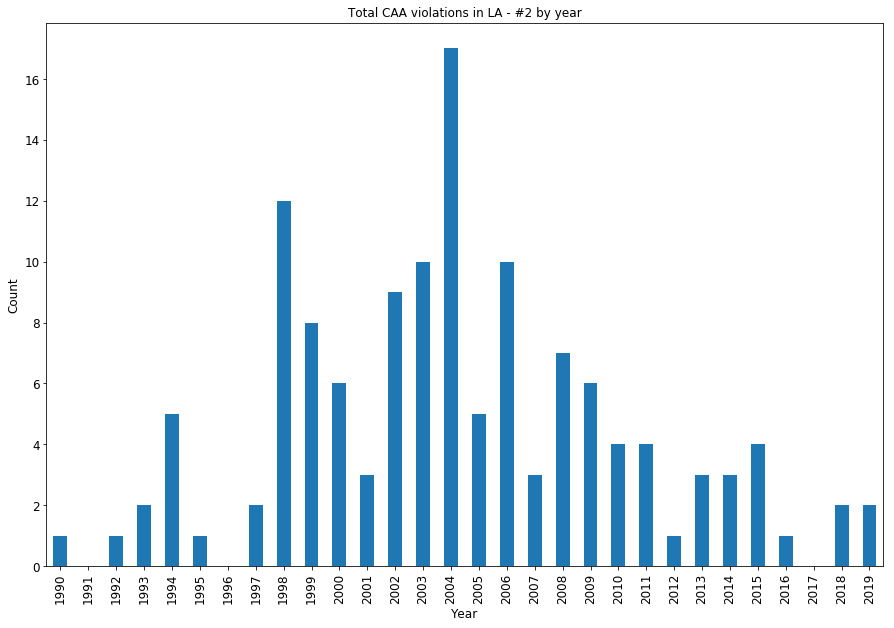

In [13]:
# This cell creates a function that will be used by both the CD and the state
# to plot the number of cases by year.
import datetime

def show_plot( df, date_field, place, date_format, chart_title ):
    
    df[date_field] = pd.to_datetime(df[date_field], format=date_format) #format

    cy = df.groupby([date_field])[date_field].count() # Use a dummy variable to count inspections.
    cy = cy.resample('Y').sum() # resample specific days to a yearly basis  
    cy = pd.DataFrame(cy) # convert to dataframe
    cy.index = cy.index.strftime('%Y') # makes the x axis (date) prettier

    chart_title +=  " in " + place + " by year"

    ax = cy.plot(kind='bar', title = chart_title, figsize=(15, 10), legend=False, fontsize=12)
    ax.set_xlabel("Year", fontsize=12)
    ax.set_ylabel("Count", fontsize=12)

chart_title = "Total CAA violations"

show_plot( my_cd_icis, 'HPV_DAYZERO_DATE', 
          my_state + ' - #' + str( my_cd ), '%m-%d-%Y', chart_title )

## Plot the number of high-priority violations by year, using the entire state.
Since the number of violations in a single CD may be small, it can be more
interesting to look at the entire state.

In [ ]:
chart_title = "Total CAA violations"

show_plot( icis_data, 'HPV_DAYZERO_DATE', \
          my_state, '%m-%d-%Y', chart_title )